<a href="https://colab.research.google.com/github/jahnvisikligar/QMUL-AI/blob/main/AI_CW2_Question2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST Classification

The libraries are imported and data is loaded in the following cell.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data as D
import time

import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(0)

train_set = torchvision.datasets.FashionMNIST(root = ".", train = True ,download = True , transform = transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root = ".", train = False ,download = True , transform = transforms.ToTensor())

def test_train_validation_split(train_set,test_set,train_ratio=0.7):
    """
    Train and Validation split 
    if train_ratio is 0.7 it will split the train_set into 70% training data, 30% Validation Data.
    * this function is not used after a calrification on forum post
    params: train_set, test_set, train_ratio
    returns: training_loader,valid_loader,test_loader
    """
    train_len = int(train_ratio*len(train_set))
    valid_len = len(train_set) - train_len
    train, valid = D.random_split(train_set, lengths=[train_len, valid_len])
    training_loader = torch.utils.data.DataLoader(train, batch_size=32,shuffle = False)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=32,shuffle = False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=32,shuffle = False)
    print("Train data len: ", len(training_loader),"Valid data len: ",len(valid_loader),"Test data len: ",len(test_loader))
    return training_loader,valid_loader,test_loader

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In the following cells, the data is analysed and simple visualisation of the data is done.

In [ ]:
training_loader,valid_loader,test_loader = test_train_validation_split(train_set,test_set,train_ratio=1)

Train data len:  1875 Valid data len:  0 Test data len:  313


In [ ]:
len(training_loader),len(valid_loader),len(test_loader)

(1875, 0, 313)

In [ ]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([32, 1, 28, 28])
torch.Size([32])


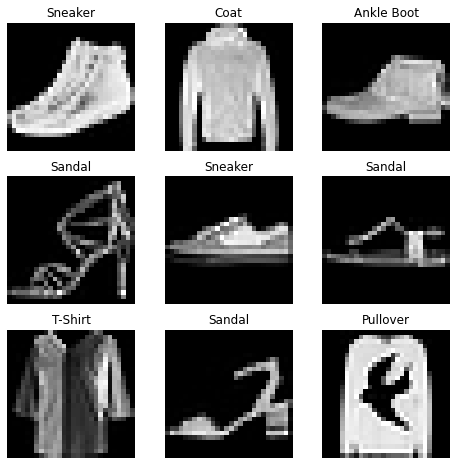

In [ ]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(8,8));
columns = 3;
rows = 3;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_set));
    img = train_set[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_set[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')

From the above we analysed that there are 10 classes of Fashion accessories, thus we would be building a Multiclass classifier.

In the following code, the CNN network is built with following specifications
```
Network(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (dropout1): Dropout(p=0.8, inplace=False)
  (out): Linear(in_features=256, out_features=10, bias=True)
)
```
Each layer is Xavier normalised.

In [ ]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
    def __init__(self,num_classes=10,activation="relu",dropout_rate=0,training_flag=True):
        super(Network, self).__init__()
        self.num_classes = num_classes # 10 here
        self.activation = activation # which activation function to employ
        self.dropout_rate = dropout_rate # if dropout then  how much
        self.training_flag = training_flag # if dropout then trainable or not
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        nn.init.xavier_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        nn.init.xavier_normal_(self.conv2.weight)
        self.fc1 = nn.Linear(in_features=1024, out_features=256)
        nn.init.xavier_normal_(self.fc1.weight)
        self.dropout1 = nn.Dropout(p=dropout_rate,inplace=False) 
        self.out = nn.Linear(in_features=256, out_features=num_classes)
        nn.init.xavier_normal_(self.out.weight)
        


    def forward(self, t):

        # conv 1
        t = self.conv1(t)
        if self.activation == "relu":
            t = torch.nn.functional.relu(t)
        if self.activation == "tanh":
            t = torch.tanh(t)
        if self.activation == "sigmoid":
            t = torch.sigmoid(t)
        if self.activation == "elu":
            t = torch.nn.functional.elu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # conv 2
        t = self.conv2(t)
        if self.activation == "relu":
            t = torch.nn.functional.relu(t)
        if self.activation == "tanh":
            t = torch.tanh(t)
        if self.activation == "sigmoid":
            t = torch.sigmoid(t)
        if self.activation == "elu":
            t = torch.nn.functional.elu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = t.view(t.size(0), -1)
        # fc1
        t = self.fc1(t)
        if self.activation == "relu":
            t = torch.nn.functional.relu(t)
        if self.activation == "tanh":
            t = torch.tanh(t)
        if self.activation == "sigmoid":
            t = torch.sigmoid(t)
        if self.activation == "elu":
            t = torch.nn.functional.elu(t)

        # output
        t = self.out(t)
        if self.dropout_rate > 0.0 and self.training_flag==True:
            t = self.dropout1(t)
        elif self.dropout_rate > 0.0 and self.training_flag==False:
            t = torch.nn.functional.dropout(t, self.dropout_rate)
        else:
            return t

        return t

Below functions are invoked to perform training and evaluation of the model 

In [ ]:
def train(model,x,y,criterion,optimizer):
    """
    train Neural Network
    """
    # zero the parameter gradients
    optimizer.zero_grad()
    
    # forward + backward + optimize
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    return loss.item()

def valid(model,x_valid,y_valid,criterion):
    """
    perform validation NN
    * This is not performed
    """
    model.eval()
    y_pred = model(x_valid)
    loss = criterion(y_pred, y_valid)
    return loss.item()

def evaluation(model,loader):
    """
    perform evalaution NN
    """
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for i, (images,labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            images = Variable(images.float())
            labels = Variable(labels)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total if total > 0 else 0

Below function is invoked each time a different parameter is set. For example, if we want to use different epoch size, below function is used and different epoch size can be set in \*params 

In [ ]:
def classify(device,model,data,criterion,optimizer,*params):
    """
    One function to perform calssification with different model parameters
    """
    num_epochs,num_classes,batch_size,learning_rate,activation = params
    training_loader,valid_loader,test_loader = data
    
    total_step = len(training_loader)
    train_losses = []
    valid_losses = []
    train_accuracy = []
    valid_accuracy = []
    test_accuracy = []
    tte = [] # time taken per epoch
    for epoch in range(num_epochs):
        loss_epoch = 0
        tte_start = time.time()

        for i, (images,labels) in enumerate(training_loader):
            model.train()
            images, labels = images.to(device), labels.to(device)
            images = Variable(images.float())
            labels = Variable(labels)
            loss = train(model,images,labels,criterion,optimizer)
            loss_epoch += loss
        train_losses.append(loss)
        
        if len(valid_loader)>0:
            for j, (images,labels) in enumerate(valid_loader):
                images, labels = images.to(device), labels.to(device)
                images = Variable(images.float())
                labels = Variable(labels)
                loss = valid(model,images,labels,criterion)
            valid_losses.append(loss)
        else:
            valid_losses.append(0)
        train_accuracy.append(evaluation(model,training_loader))
        valid_accuracy.append(evaluation(model,valid_loader))
        test_accuracy.append(evaluation(model,test_loader))
        tte_end = time.time()
        elapsed_time = tte_end-tte_start
        tte.append(elapsed_time)
        print ('Epoch [{}/{}] {:.2f} sec, loss_epoch: {:.2f} ,loss: {:.4f}, acc: {:.4f}, v_loss: {:.1f}, v_acc: {:.1f}, test_acc: {:.4f}'.format(epoch+1, num_epochs, elapsed_time,loss_epoch,train_losses[-1], train_accuracy[-1], valid_losses[-1], valid_accuracy[-1],test_accuracy[-1]))

    final_test_accuracy = evaluation(model,test_loader)
    print('Test Accuracy of the model: {:.4f} %'.format(100 * final_test_accuracy))
    print('Total Time taken: {:.3f} sec'.format(sum(tte)))
    return train_losses, valid_losses, train_accuracy, valid_accuracy, test_accuracy, final_test_accuracy, sum(tte)

Below Code is performing Q1 a and b, epoch size is 50, SGD optimiser, learning rate is 0.1 and CrossEntropyLoss. 

In [ ]:
result = []
num_epochs = 50
num_classes = 10
batch_size = 100
learning_rate = 0.1
activation = "relu"
dropout_rate = 0
training_flag = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Network(num_classes,activation=activation,dropout_rate=dropout_rate,training_flag=training_flag).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)
data = test_train_validation_split(train_set,test_set,train_ratio=1)
[training_loader,valid_loader,test_loader] = data 

t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time = classify(device,net,data,criterion,optimizer,num_epochs,num_classes,batch_size,learning_rate,activation)
end = [learning_rate,activation,dropout_rate,num_epochs,t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time]
result.append(end)

Train data len:  1875 Valid data len:  0 Test data len:  313
Epoch [1/50] 95.17 sec, loss_epoch: 961.51 ,loss: 0.1041, acc: 0.8729, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8576
Epoch [2/50] 93.68 sec, loss_epoch: 608.06 ,loss: 0.0827, acc: 0.8911, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8740
Epoch [3/50] 92.38 sec, loss_epoch: 521.02 ,loss: 0.0534, acc: 0.9035, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8857
Epoch [4/50] 92.04 sec, loss_epoch: 462.93 ,loss: 0.0546, acc: 0.9118, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8906
Epoch [5/50] 91.97 sec, loss_epoch: 417.62 ,loss: 0.0522, acc: 0.9159, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8926
Epoch [6/50] 92.41 sec, loss_epoch: 377.21 ,loss: 0.0463, acc: 0.9221, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8936
Epoch [7/50] 92.30 sec, loss_epoch: 339.85 ,loss: 0.0303, acc: 0.9253, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8911
Epoch [8/50] 92.34 sec, loss_epoch: 305.29 ,loss: 0.0277, acc: 0.9318, v_loss: 0.0, v_acc: 0.0, test_acc: 0.8947
Epoch [9/50] 92.80 sec, loss_epoch:

Saving the model to 'model.ckpt' file.

In [ ]:
torch.save(net.state_dict(), 'model.ckpt')

NameError: ignored

Below code is to get results of different activation functions namely "tanh","sigmoid","elu".

In [ ]:
for activation in ["tanh","sigmoid","elu"]:
    num_epochs = 50
    num_classes = 10
    batch_size = 100
    learning_rate = 0.1
    dropout_rate = 0
    # activations = ["tanh","sigmoid","elu"]
    print(activation)
    training_flag = True
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = Network(num_classes,activation=activation,dropout_rate=dropout_rate,training_flag=training_flag).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    data = test_train_validation_split(train_set,test_set,train_ratio=1)
    [training_loader,valid_loader,test_loader] = data 

    t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time = classify(device,net,data,criterion,optimizer,num_epochs,num_classes,batch_size,learning_rate,activation)
    end = [learning_rate,activation,dropout_rate,num_epochs,t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time]
    result.append(end)

Below code is to get reults of perfomace of model for different learning rates 0.001, 0.1, 0.5, 1, 10

In [ ]:
for learning_rate in [0.001,0.1,0.5,1,10]:
    num_epochs = 50
    num_classes = 10
    batch_size = 100
#     learning_rate = 0.1
    activation = "relu"
    dropout_rate = 0
    print(learning_rate)
    training_flag = True
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = Network(num_classes,activation=activation,dropout_rate=dropout_rate,training_flag=training_flag).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    data = test_train_validation_split(train_set,test_set,train_ratio=1)
    [training_loader,valid_loader,test_loader] = data 

    t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time = classify(device,net,data,criterion,optimizer,num_epochs,num_classes,batch_size,learning_rate,activation)
    end = [learning_rate,activation,dropout_rate,num_epochs,t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time]
    result.append(end)

Below code is to get results of performace of the model when a dropout layer is applied using `nn.Dropout()` layer 

In [ ]:
for dropout_rate in [0.3,0.1,0.8]:
    num_epochs = 50
    num_classes = 10
    batch_size = 100
    learning_rate = 0.1
    activation = "relu"
    # dropout_rate = [0.3,0.1,0.8]
    training_flag = True
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = Network(num_classes,activation=activation,dropout_rate=dropout_rate,training_flag=training_flag).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    data = test_train_validation_split(train_set,test_set,train_ratio=1)
    [training_loader,valid_loader,test_loader] = data 

    t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time = classify(device,net,data,criterion,optimizer,num_epochs,num_classes,batch_size,learning_rate,activation)
    end = [learning_rate,activation,dropout_rate,num_epochs,t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time]
    result.append(end)

From the above we can see that dropout penalty is applied only during training and not during evalaution. This has been discussed here https://stackoverflow.com/questions/53419474/using-dropout-in-pytorch-nn-dropout-vs-f-dropout

The below code uses `torch.nn.functional.dropout()` to apply dropout to the layers, using this it penalises the network irerespective of its phase, training or evalaution. The results are conclusive.

In [ ]:
for dropout_rate in [0.3,0.1,0.8]:
    num_epochs = 50
    num_classes = 10
    batch_size = 100
    learning_rate = 0.1
    activation = "relu"
    # dropout_rate = [0.3,0.1,0.8]
    training_flag = False
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = Network(num_classes,activation=activation,dropout_rate=dropout_rate,training_flag=training_flag).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    data = test_train_validation_split(train_set,test_set,train_ratio=1)
    [training_loader,valid_loader,test_loader] = data 

    t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time = classify(device,net,data,criterion,optimizer,num_epochs,num_classes,batch_size,learning_rate,activation)
    end = [learning_rate,activation,dropout_rate,num_epochs,t_loss,v_loss,t_acc,v_acc,test_acc,final_test_accuracy,exec_time]
    result.append(end)

Saving and tranforming all the results to  a usable format in pandas, dataframe.

In [ ]:
import pandas as pd
df = pd.DataFrame(result, columns = ['learning_rate','activation','dropout_rate','num_epochs','t_loss','v_loss','t_acc','v_acc','test_acc','final_test_accuracy','exec_time']) 
df['final_train_acc'] = df.apply(lambda x: x.t_acc[-1],axis = 1)
df.to_csv("results.csv",header=False)

In [ ]:
df.head(3)

Q2 b results

In [ ]:
pd.DataFrame([[df.loc[0, ['final_train_acc']][0],df.loc[0, ['final_test_accuracy']][0]]],columns=['Final Train Accuracy','Final Test Acurracy'])

In [ ]:
t_acc = df.loc[0, ['t_acc']][0]
t_loss = df.loc[0, ['t_loss']][0]
test_acc = df.loc[0, ['test_acc']][0]

fig = plt.figure(figsize=(12,5))
subfig = fig.add_subplot(121)
subfig.plot(t_acc, 'o-' ,label="training")
subfig.plot(test_acc, label="train")
subfig.set_title('Training and Test Accuracy')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('accuracy')
subfig.legend(loc='upper left')
subfig = fig.add_subplot(122)
subfig.plot(t_loss, 'o-' ,label="training")
# subfig.plot(v_loss, label="validation")
subfig.set_title('Training Loss per epoch')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('loss')
subfig.legend(loc='upper left')

Q2 c Activation function

In [ ]:
options = ['sigmoid','tanh','elu']
df[df['activation'].isin(options)].loc[:,['activation','final_train_acc','final_test_accuracy']]

In [ ]:
options = ['sigmoid','tanh','elu']
d_act_ = df[df['activation'].isin(options)].loc[:,['t_acc','test_acc','t_loss']]
df[df['activation'].isin(options)].loc[:,['t_acc','test_acc','t_loss']]

In [ ]:
d_act_t_acc = d_act_['t_acc']
d_act_test_acc = d_act_['test_acc']
d_act_t_loss = d_act_['t_loss']

fig = plt.figure(figsize=(12,5))
subfig = fig.add_subplot(121)
subfig.plot(t_acc ,label="relu")
subfig.plot(d_act_t_acc[1] ,label="tanh")
subfig.plot(d_act_t_acc[2] ,label="sigmoid")
subfig.plot(d_act_t_acc[3] ,label="elu")
subfig.set_title('Train Accuracy on different Activation functions')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('Acc')
subfig.legend(loc='upper left')
subfig = fig.add_subplot(122)
subfig.plot(test_acc ,label="relu")
subfig.plot(d_act_test_acc[1] ,label="tanh")
subfig.plot(d_act_test_acc[2] ,label="sigmoid")
subfig.plot(d_act_test_acc[3] ,label="elu")
subfig.set_title('Train Accuracy and Loss on 0.100 Dropout')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('Perf')
subfig.legend(loc='upper left')

fig = plt.figure(figsize=(12,5))
subfig = fig.add_subplot(121)
subfig.plot(t_loss ,label="relu")
subfig.plot(d_act_t_loss[1] ,label="tanh")
subfig.plot(d_act_t_loss[2] ,label="sigmoid")
subfig.plot(d_act_t_loss[3] ,label="elu")
subfig.set_title('Train Accuracy on different Activation functions')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('loss')
subfig.legend(loc='upper left')

Q3 c learning rate

In [ ]:
option1 = ['relu']
option2 = [0.0]
options3 = [0.001,0.1,0.5,1,10]
d = df.loc[df['activation'].isin(option1)] 
d = d.loc[d['dropout_rate'].isin(option2)] 
d[d['learning_rate'].isin(options3)].loc[:,['activation','learning_rate','final_train_acc','final_test_accuracy']][1:6]

In [ ]:
option1 = ['relu']
option2 = [0.0]
options3 = [0.001,0.1,0.5,1,10]
d = df.loc[df['activation'].isin(option1)] 
d = d.loc[d['dropout_rate'].isin(option2)] 
d = d[d['learning_rate'].isin(options3)].loc[:,['t_acc','t_loss']][1:6]

In [ ]:
d_t_acc = d['t_acc']
d_t_loss = d['t_loss']
d

In [ ]:
fig = plt.figure(figsize=(12,5))
subfig = fig.add_subplot(121)
subfig.plot(d_t_acc[4] ,label="Acc")
subfig.plot(d_t_loss[4] ,label="Loss")
subfig.set_title('Train Accuracy and Loss on 0.001 Dropout')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('Perf')
subfig.legend(loc='lower right')
subfig = fig.add_subplot(122)
subfig.plot(d_t_acc[5] ,label="Acc")
subfig.plot(d_t_loss[5] ,label="Loss")
subfig.set_title('Train Accuracy and Loss on 0.100 Dropout')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('Perf')
subfig.legend(loc='lower right')

fig = plt.figure(figsize=(12,5))
subfig = fig.add_subplot(121)
subfig.plot(d_t_acc[6] ,label="Acc")
subfig.plot(d_t_loss[6] ,label="Loss")
subfig.set_title('Train Accuracy and Loss on 0.500 Dropout')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('Perf')
subfig.legend(loc='lower right')
subfig = fig.add_subplot(122)
subfig.plot(d_t_acc[7] ,label="Acc")
subfig.plot(d_t_loss[7] ,label="Loss")
subfig.set_title('Train Accuracy and Loss on 1.000 Dropout')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('Perf')
subfig.legend(loc='lower right')

Q2 d, here we analyse the results obtained for different dropouts using different methods.
The issue is decribed here https://stackoverflow.com/questions/53419474/using-dropout-in-pytorch-nn-dropout-vs-f-dropout and for this we have obtained different results.

In [ ]:
options = [0.1,0.3,0.5]
df[df['dropout_rate'].isin(options)].loc[:,['dropout_rate','final_train_acc','final_test_accuracy']]

In [ ]:
t_acc = df.loc[9, ['t_acc']][0]
test_acc = df.loc[9, ['test_acc']][0]
t_loss = df.loc[9, ['t_loss']][0]
fig = plt.figure(figsize=(12,5))
subfig = fig.add_subplot(121)
subfig.plot(t_acc, 'o-' ,label="training")
subfig.plot(test_acc, label="train")
subfig.set_title('Training and Test Accuracy')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('accuracy')
subfig.legend(loc='upper left')
subfig = fig.add_subplot(122)
subfig.plot(t_loss, 'o-' ,label="training")
# subfig.plot(v_loss, label="validation")
subfig.set_title('Training Loss per epoch')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('loss')
subfig.legend(loc='upper left')

In [ ]:
t_acc = df.loc[12, ['t_acc']][0]
test_acc = df.loc[12, ['test_acc']][0]
t_loss = df.loc[12, ['t_loss']][0]
fig = plt.figure(figsize=(12,5))
subfig = fig.add_subplot(121)
subfig.plot(t_acc, 'o-' ,label="training")
subfig.plot(test_acc, label="train")
subfig.set_title('Training and Test Accuracy')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('accuracy')
subfig.legend(loc='upper left')
subfig = fig.add_subplot(122)
subfig.plot(t_loss, 'o-' ,label="training")
# subfig.plot(v_loss, label="validation")
subfig.set_title('Training Loss per epoch')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('loss')
subfig.legend(loc='upper left')

In [ ]:
t_loss = df[-3:]['t_loss']
t_acc = df[-3:]['t_acc']

fig = plt.figure(figsize=(12,5))
subfig = fig.add_subplot(121)
subfig.plot(t_loss[12] ,label="0.3")
subfig.plot(t_loss[13] ,label="0.1")
subfig.plot(t_loss[14] ,label="0.8")
subfig.set_title('Different dropout effect on Training Loss')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('Loss')
subfig.legend(loc='upper left')
subfig = fig.add_subplot(122)
subfig.plot(t_acc[12] ,label="0.3")
subfig.plot(t_acc[13] ,label="0.1")
subfig.plot(t_acc[14] ,label="0.8")
subfig.set_title('Different dropout effect on Training Acurracy')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('accuracy')
subfig.legend(loc='upper left')

In [ ]:
t_loss = df[-6:-3]['t_loss']
t_acc = df[-6:-3]['t_acc']

In [ ]:
fig = plt.figure(figsize=(12,5))
subfig = fig.add_subplot(121)
subfig.plot(t_loss[9] ,label="0.3")
subfig.plot(t_loss[10] ,label="0.1")
subfig.plot(t_loss[11] ,label="0.8")
subfig.set_title('Different dropout effect on Training Loss')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('Loss')
subfig.legend(loc='upper left')
subfig = fig.add_subplot(122)
subfig.plot(t_acc[9] ,label="0.3")
subfig.plot(t_acc[10] ,label="0.1")
subfig.plot(t_acc[11] ,label="0.8")
subfig.set_title('Different dropout effect on Training Acurracy')
subfig.set_xlabel('Epoch')
subfig.set_ylabel('accuracy')
subfig.legend(loc='upper left')